In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image
from nilearn import signal
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiMapsMasker
from nilearn.plotting import plot_roi, plot_stat_map,plot_epi
from nilearn.image import new_img_like
from nilearn import datasets, surface, plotting
import nilearn as nl 
import nibabel as nib
from nilearn import datasets
from sklearn.decomposition import PCA
import bids
import os
import glob
import ray
import psutil


# Homemade functions

In [2]:
ray.shutdown()

num_cpus = psutil.cpu_count(logical=False)

ray.init(num_cpus=num_cpus)

@ray.remote
def fit_mask_get_PC1(current_mask, sub_data):
    try:
        fit_2_mask = current_mask.fit_transform(sub_data)
        PCA_instance = PCA(n_components=1)
        PCA_instance.fit(fit_2_mask)
        PC1_score = PCA_instance.explained_variance_ratio_[0]
    except ValueError:
        PC1_score = 0
    return PC1_score


2023-11-25 13:11:31,416	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [392]:
ray.shutdown()

num_cpus = psutil.cpu_count(logical=False)

ray.init(num_cpus=num_cpus)

@ray.remote
def apply_GM_Mask_2_RS(rs_data, gm_data, current_participant, condition, save_folder): 
    
    # Load gm mask raw data
    gm_data_file = nib.load(gm_data) 

    # Create first mask using (mask_type="gm")
    gm_mask1 = nl.masking.compute_brain_mask(gm_data_file, mask_type="gm", opening=False) 

    # Create second mask as a "NiftiMasker" obj.
    gm_mask2 = NiftiMasker(gm_mask1).fit() 

    # Apply gm_mask2 to rs_data.  
    rs_data_masked = gm_mask2.fit_transform(rs_data)

    # Convert rs_data_masked to volumetric shape.
    rs_data_masked_vol = gm_mask2.inverse_transform(rs_data_masked)

    # Save "rs_data_masked_vol" as ".nii" file.
    new_file_name = save_folder + condition + current_participant + "_gm_masked_vol.nii.gz"
    rs_data_masked_vol.to_filename(new_file_name)


2023-09-18 08:56:21,665	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [29]:
ray.shutdown()

In [14]:
def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            return file

def get_anat_files(path):
    
    str_list = glob.glob(path + '*c1*')
    
    if os.path.isfile(str_list[0]):
       
        file = str_list[0]

        #print(file)

        return file
    else: 
        print("Not yet.")
        print(str(glob.glob(path + 'wc1mpr*')))

## Open Directory

In [15]:
# Now open a directory/folder 
fd = os.open("/Users/luisalvarez/Documents/Research_Elective_Data", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Research_Elective_Data


In [16]:
# Get list of GM_COC files. 
dir_path_coc = str(os.getcwd() + "/COCGM_files/")
COC_paths = glob.glob(dir_path_coc + '*nii*')
print("Number of COC files: " + str(len(COC_paths)))

# Get list of GM_PLA files. 
dir_path_pla = str(os.getcwd() + "/PLAGM_files/")
PLA_paths = glob.glob(dir_path_pla + '*nii*')
print("Number of PLA files: " + str(len(PLA_paths)))
        
# Get list of participating subjects. 
p_path = str(os.getcwd() + "/CANCOC_PP_1")
paritipants_list = os.listdir(p_path)
paritipants_list.pop(0)
print("paritipants_list: " + str(paritipants_list))


Number of COC files: 40
Number of PLA files: 40
paritipants_list: ['P5259', 'P5232', 'P5235', 'P5203', 'P5258', 'P52125', 'P5260', 'P5205', 'P5234', 'P5233', 'P5211', 'P5229', 'P5216', 'P5220', 'P5218', 'P5227', 'P5245', 'P5228', 'P5210', 'P5244', 'P5243', 'P5236', 'P5209', 'P5231', 'P5207', 'P5238', 'P5254', 'P5253', 'P5201', 'P5206', 'P5230', 'P5237', 'P5208', 'P5252', 'P5215', 'P5212', 'P5224', 'P5247', 'P5249', 'P5225']


# Load functional image for subject 1 (P5259)

In [8]:
tr_drop = 5
sub1_coc = image.load_img(COC_paths[0])
sub1_pla = image.load_img(PLA_paths[0])

#Remove the first 5 TRs
sub1_coc = sub1_coc.slicer[:,:,:,tr_drop:]
sub1_pla = sub1_pla.slicer[:,:,:,tr_drop:]

print("sub1_coc shape: %s" % str(sub1_coc.shape))
print("sub1_pla shape: %s" % str(sub1_pla.shape))


sub1_coc shape: (91, 109, 91, 233)
sub1_pla shape: (91, 109, 91, 151)


# Brain parcellations


### AAL template for spm 12

In [17]:
AA = datasets.fetch_atlas_aal()


In [18]:
# Location of AA parcellation atlas

AA_maps = AA.maps 

AA_labels = AA.labels

AA_indices = AA.indices

print("AA_labels: " + str(AA_labels))
print("AA_indices: " + str(AA_indices))

AA_labels: ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusif

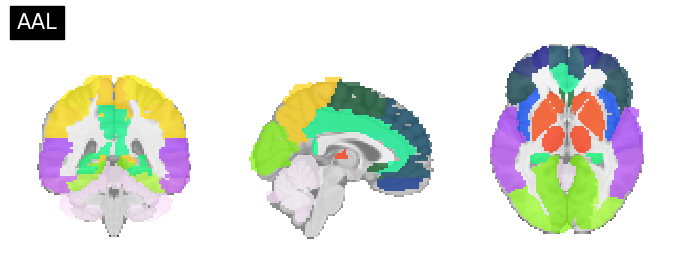

In [19]:
# Visualize parcellation atlas
plot_roi(AA_maps, draw_cross=False, annotate=False, title="AAL")

# Check the fit/shape of each of AAL ROI's

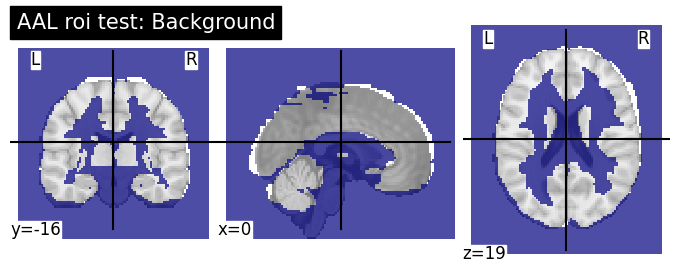

In [20]:
aal_roi_test = nl.image.new_img_like(AA_maps, nl.image.get_data(AA_maps) == int(0))

plotting_test = plot_roi(aal_roi_test, black_bg=False, title=str("AAL roi test: Background" ))

In [14]:
# Re-sample sub1 coc and pla files, and generate background images to plot each roi.

sub1_coc_re_AA = image.resample_to_img(sub1_coc, AA_maps, interpolation='nearest')
sub1_pla_re_AA = image.resample_to_img(sub1_pla, AA_maps, interpolation='nearest')

sub1_coc_re_AA_mean = image.mean_img(sub1_coc_re_AA)
sub1_pla_re_AA_mean = image.mean_img(sub1_pla_re_AA)

In [11]:

#roi_img = nl.image.new_img_like(AA_maps, nl.image.get_data(AA_maps) == int( AA_indices[0] ))

#masker = NiftiMasker(mask_img=roi_img, verbose=False).fit()

#plotting_pla = plot_roi(roi_img, bg_img=sub1_coc_re_AA_mean, black_bg=False, title=str("PLA: " + AA_labels[0]))

In [21]:
# So, I'm creating a mask for each roi/network in AA atlas and storing it in the variable below.
# Also, the loop below generates two images per roi (one using sub_1_coc as background and another one using sub_1_pla)
# each image is saved into folder Yeo_Roi_img.
aa_roi_masks = []

for x in range(116):
    
    print("Computing and plotting roi_" +str(x) +": " + str(AA_labels[x]))
    roi_img =nl.image.new_img_like(AA_maps, nl.image.get_data(AA_maps) == int(AA_indices[x]))
    masker = NiftiMasker(mask_img=roi_img, verbose=False).fit()
    aa_roi_masks.append(masker)

    if(x==115):
        break

    #masker_img = masker.mask_img_

    #output_name = "AA_Roi_img/AA_Roi_" + str(AA_labels[x])
    #output_nifti_name = "Yeo_Roi_" + str(yeo_labels[x]) + ".nii.gz"

    #plotting_pla = plot_roi(masker_img, bg_img=sub1_coc_re_AA_mean, black_bg=False, title=str("PLA: " + AA_labels[x]))

    #plotting_coc = plot_roi(masker_img, bg_img=sub1_coc_re_yeo_mean, black_bg=False, title=str("COC: " + yeo_labels[x]))
    
    #output_nifti = nl.image.new_img_like(masker_img, yeo_labels[x])
    #output_nifti.to_filename(output_nifti_name)
    
    #plotting_pla.savefig(output_name)
    #plotting_coc.savefig(output_name_coc)
    

Computing and plotting roi_0: Precentral_L
Computing and plotting roi_1: Precentral_R
Computing and plotting roi_2: Frontal_Sup_L
Computing and plotting roi_3: Frontal_Sup_R
Computing and plotting roi_4: Frontal_Sup_Orb_L
Computing and plotting roi_5: Frontal_Sup_Orb_R
Computing and plotting roi_6: Frontal_Mid_L
Computing and plotting roi_7: Frontal_Mid_R
Computing and plotting roi_8: Frontal_Mid_Orb_L
Computing and plotting roi_9: Frontal_Mid_Orb_R
Computing and plotting roi_10: Frontal_Inf_Oper_L
Computing and plotting roi_11: Frontal_Inf_Oper_R
Computing and plotting roi_12: Frontal_Inf_Tri_L
Computing and plotting roi_13: Frontal_Inf_Tri_R
Computing and plotting roi_14: Frontal_Inf_Orb_L
Computing and plotting roi_15: Frontal_Inf_Orb_R
Computing and plotting roi_16: Rolandic_Oper_L
Computing and plotting roi_17: Rolandic_Oper_R
Computing and plotting roi_18: Supp_Motor_Area_L
Computing and plotting roi_19: Supp_Motor_Area_R
Computing and plotting roi_20: Olfactory_L
Computing and p

In [19]:
#matplotlib.pyplot.close()

# Estimating PC1 for each mask/roi

In [18]:
# Create Dataframe to store each participants PC1 scores. 

COC_PC1_AA_scores_df = pd.DataFrame(columns=AA_labels)
PLA_PC1_AA_scores_df = pd.DataFrame(columns=AA_labels)

zeros_holder = np.zeros((1, 116))

dir_path = os.getcwd()
dir_path += "/CANCOC_PP_1"

# Loop below for paticipants in "PP_1"
for path in os.listdir("CANCOC_PP_1"):
    #print(os.path.join(dir_path, path))
    if os.path.isdir(os.path.join(dir_path, path)): 
           
        current_p_df = pd.DataFrame(data=zeros_holder, columns=AA_labels, index=[path])
        COC_PC1_AA_scores_df = COC_PC1_AA_scores_df.append(current_p_df, ignore_index=False)
        PLA_PC1_AA_scores_df = PLA_PC1_AA_scores_df.append(current_p_df, ignore_index=False)


#COC_PC1_AA_scores_df.head(40)

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_99281/1202629617.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  COC_PC1_AA_scores_df = COC_PC1_AA_scores_df.append(current_p_df, ignore_index=False)
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_99281/1202629617.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PLA_PC1_AA_scores_df = PLA_PC1_AA_scores_df.append(current_p_df, ignore_index=False)
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_99281/1202629617.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  COC_PC1_AA_scores_df = COC_PC1_AA_scores_df.append(current_p_df, ignore_index=False)
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_99281/1202629617.py:18: FutureWa

In [18]:
#sub1_COC_PC1_scores = []
#sub2_COC_PC1_scores = []
#sub3_COC_PC1_scores = []
#sub4_COC_PC1_scores = []
#sub5_COC_PC1_scores = []
#sub6_COC_PC1_scores = []
#sub7_COC_PC1_scores = []
#sub8_COC_PC1_scores = []
#sub9_COC_PC1_scores = []
#sub10_COC_PC1_scores = []
#sub11_COC_PC1_scores = []
#sub12_COC_PC1_scores = []
#sub13_COC_PC1_scores = []
#sub14_COC_PC1_scores = []
#sub15_COC_PC1_scores = []
#sub16_COC_PC1_scores = []
#sub17_COC_PC1_scores = []
#sub18_COC_PC1_scores = []
#sub19_COC_PC1_scores = []
#sub20_COC_PC1_scores = []
#sub21_COC_PC1_scores = []
#sub22_COC_PC1_scores = []
#sub23_COC_PC1_scores = []
#sub24_COC_PC1_scores = []
#sub25_COC_PC1_scores = []
#sub26_COC_PC1_scores = []
#sub27_COC_PC1_scores = []
#sub28_COC_PC1_scores = []
#sub29_COC_PC1_scores = []
#sub30_COC_PC1_scores = []
#sub31_COC_PC1_scores = []
#sub32_COC_PC1_scores = []
#sub33_COC_PC1_scores = []
#sub34_COC_PC1_scores = []
#sub35_COC_PC1_scores = []
#sub36_COC_PC1_scores = []
#sub37_COC_PC1_scores = []
#sub38_COC_PC1_scores = []
#sub39_COC_PC1_scores = []
#sub40_COC_PC1_scores = []

for current_roi in range(116):
    
    #sub1_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[0]))
    #sub2_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[1]))
    #sub3_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[2]))
    #sub4_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[3]))
    #sub5_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[4]))
    #sub6_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[5]))
    #sub7_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[6]))
    #sub8_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[7]))
    #sub9_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[8]))
    #sub10_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[9]))
    #sub11_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[10]))
    #sub12_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[11]))
    #sub13_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[12]))
    #sub14_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[13]))
    #sub15_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[14]))
    #sub16_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[15]))
    #sub17_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[16]))
    #sub18_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[17]))
    #sub19_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[18]))
    #sub20_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[19]))
    #sub21_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[20]))
    #sub22_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[21]))
    #sub23_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[22]))
    #sub24_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[23]))
    #sub25_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[24]))
    #sub26_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[25]))
    #sub27_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[26]))
    #sub28_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[27]))
    #sub29_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[28]))
    #sub30_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[29]))
    #sub31_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[30]))
    #sub32_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[31]))
    #sub33_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[32]))
    #sub34_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[33]))
    #sub35_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[34]))
    #sub36_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[35]))
    #sub37_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[36]))
    #sub38_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[37]))
    #sub39_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[38]))
    #sub40_COC_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], COC_paths[39]))
   
   




(pid=72905) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
(pid=72905)   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(fit_mask_get_PC1 pid=72905) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: invalid value encountered in divide
(fit_mask_get_PC1 pid=72905)   self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()
(fit_mask_get_PC1 pid=72907) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: invalid value encountered in divide
(fit_mask_get_PC1 pid=72907)   self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()
(fit_mask_get_PC1 pid=72905) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: invalid value encountered in divide
(fit_mask_get_PC1 pid=72905)   self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()
(fit_mask_get_PC1 pid=72907) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: invalid

In [35]:
#sub1_GMCOC_scores = ray.get(sub1_COC_PC1_scores) 
#sub2_GMCOC_scores = ray.get(sub2_COC_PC1_scores) 
#sub3_GMCOC_scores = ray.get(sub3_COC_PC1_scores) 
#sub4_GMCOC_scores = ray.get(sub4_COC_PC1_scores) 
#sub5_GMCOC_scores = ray.get(sub5_COC_PC1_scores) 
#sub6_GMCOC_scores = ray.get(sub6_COC_PC1_scores) 
#sub7_GMCOC_scores = ray.get(sub7_COC_PC1_scores) 
#sub8_GMCOC_scores = ray.get(sub8_COC_PC1_scores) 
#sub9_GMCOC_scores = ray.get(sub9_COC_PC1_scores) 
#sub10_GMCOC_scores = ray.get(sub10_COC_PC1_scores) 
#sub11_GMCOC_scores = ray.get(sub11_COC_PC1_scores) 
#sub12_GMCOC_scores = ray.get(sub12_COC_PC1_scores) 
#sub13_GMCOC_scores = ray.get(sub13_COC_PC1_scores)
#sub14_GMCOC_scores = ray.get(sub14_COC_PC1_scores) 
#sub15_GMCOC_scores = ray.get(sub15_COC_PC1_scores) 
#sub16_GMCOC_scores = ray.get(sub16_COC_PC1_scores) 
#sub17_GMCOC_scores = ray.get(sub17_COC_PC1_scores) 
#sub18_GMCOC_scores = ray.get(sub18_COC_PC1_scores) 
#sub19_GMCOC_scores = ray.get(sub19_COC_PC1_scores) 
#sub20_GMCOC_scores = ray.get(sub20_COC_PC1_scores) 
#sub21_GMCOC_scores = ray.get(sub21_COC_PC1_scores) 
#sub22_GMCOC_scores = ray.get(sub22_COC_PC1_scores) 
#sub23_GMCOC_scores = ray.get(sub23_COC_PC1_scores) 
#sub24_GMCOC_scores = ray.get(sub24_COC_PC1_scores) 
#sub25_GMCOC_scores = ray.get(sub25_COC_PC1_scores) 
#sub26_GMCOC_scores = ray.get(sub26_COC_PC1_scores) 
#sub27_GMCOC_scores = ray.get(sub27_COC_PC1_scores) 
#sub28_GMCOC_scores = ray.get(sub28_COC_PC1_scores) 
#sub29_GMCOC_scores = ray.get(sub29_COC_PC1_scores) 
#sub30_GMCOC_scores = ray.get(sub30_COC_PC1_scores) 
#sub31_GMCOC_scores = ray.get(sub31_COC_PC1_scores) 
#sub32_GMCOC_scores = ray.get(sub32_COC_PC1_scores) 
#sub33_GMCOC_scores = ray.get(sub33_COC_PC1_scores) 
#sub34_GMCOC_scores = ray.get(sub34_COC_PC1_scores) 
#sub35_GMCOC_scores = ray.get(sub35_COC_PC1_scores) 
#sub36_GMCOC_scores = ray.get(sub36_COC_PC1_scores) 
#sub37_GMCOC_scores = ray.get(sub37_COC_PC1_scores) 
#sub38_GMCOC_scores = ray.get(sub38_COC_PC1_scores) 
#sub39_GMCOC_scores = ray.get(sub39_COC_PC1_scores) 
#sub40_GMCOC_scores = ray.get(sub40_COC_PC1_scores) 

#COC_PC1_AA_scores_df.iloc[0] = sub1_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[1] = sub2_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[2] = sub3_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[3] = sub4_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[4] = sub5_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[5] = sub6_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[6] = sub7_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[7] = sub8_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[8] = sub9_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[9] = sub10_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[10] = sub11_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[11] = sub12_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[12] = sub13_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[13] = sub14_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[14] = sub15_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[15] = sub16_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[16] = sub17_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[17] = sub18_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[18] = sub19_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[19] = sub20_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[20] = sub21_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[21] = sub22_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[22] = sub23_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[23] = sub24_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[24]  = sub25_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[25]  = sub26_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[26]  = sub27_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[27]  = sub28_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[28]  = sub29_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[29]  = sub30_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[30]  = sub31_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[31]  = sub32_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[32]  = sub33_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[33]  = sub34_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[34]  = sub35_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[35]  = sub36_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[36]  = sub37_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[37]  = sub38_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[38]  = sub39_GMCOC_scores[:]
#COC_PC1_AA_scores_df.iloc[39]  = sub40_GMCOC_scores[:]

#COC_PC1_AA_scores_df.head(40)


In [29]:
#sub1_PLA_PC1_scores = []
#sub2_PLA_PC1_scores = []
#sub3_PLA_PC1_scores = []
#sub4_PLA_PC1_scores = []
#sub5_PLA_PC1_scores = []
#sub6_PLA_PC1_scores = []
#sub7_PLA_PC1_scores = []
#sub8_PLA_PC1_scores = []
#sub9_PLA_PC1_scores = []
#sub10_PLA_PC1_scores = []
#sub11_PLA_PC1_scores = []
#sub12_PLA_PC1_scores = []
#sub13_PLA_PC1_scores = []
#sub14_PLA_PC1_scores = []
#sub15_PLA_PC1_scores = []
#sub16_PLA_PC1_scores = []
#sub17_PLA_PC1_scores = []
#sub18_PLA_PC1_scores = []
#sub19_PLA_PC1_scores = []
#sub20_PLA_PC1_scores = []

#sub21_PLA_PC1_scores = []
#sub22_PLA_PC1_scores = []
#sub23_PLA_PC1_scores = []
#sub24_PLA_PC1_scores = []
#sub25_PLA_PC1_scores = []

#sub26_PLA_PC1_scores = []
#sub27_PLA_PC1_scores = []
#sub28_PLA_PC1_scores = []
#sub29_PLA_PC1_scores = []
#sub30_PLA_PC1_scores = []
#sub31_PLA_PC1_scores = []
#sub32_PLA_PC1_scores = []
#sub33_PLA_PC1_scores = []
#sub34_PLA_PC1_scores = []
#sub35_PLA_PC1_scores = []

#sub36_PLA_PC1_scores = []
#sub37_PLA_PC1_scores = []
#sub38_PLA_PC1_scores = []
#sub39_PLA_PC1_scores = []
#sub40_PLA_PC1_scores = []


for current_roi in range(116):
    
    #sub1_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[0]))
    #sub2_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[1]))
    #sub3_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[2]))
    #sub4_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[3]))
    #sub5_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[4]))
    #sub6_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[5]))
    #sub7_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[6]))
    #sub8_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[7]))
    #sub9_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[8]))
    #sub10_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[9]))
    #sub11_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[10]))
    #sub12_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[11]))
    #sub13_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[12]))
    #sub14_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[13]))
    #sub15_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[14]))
    #sub16_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[15]))
    #sub17_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[16]))
    #sub18_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[17]))
    #sub19_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[18]))
    #sub20_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[19]))
    #sub21_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[20]))
    #sub22_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[21]))
    #sub23_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[22]))
    #sub24_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[23]))
    #sub25_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[24]))
    #sub26_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[25]))
    #sub27_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[26]))
    #sub28_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[27]))
    #sub29_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[28]))
    #sub30_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[29]))
    #sub31_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[30]))
    #sub32_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[31]))
    #sub33_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[32]))
    #sub34_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[33]))
    #sub35_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[34]))

    #sub36_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[35]))
    #sub37_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[36]))
    #sub38_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[37]))
    #sub39_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[38]))
    #sub40_PLA_PC1_scores.append(fit_mask_get_PC1.remote(aa_roi_masks[current_roi], PLA_paths[39]))
    
   

(pid=4718) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
(pid=4718)   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
(fit_mask_get_PC1 pid=4715) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in divide
(fit_mask_get_PC1 pid=4715)   explained_variance_ratio_ = explained_variance_ / total_var
(pid=4715) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3 [repeated 3x across cluster]
(pid=4715)   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}" [repeated 3x across cluster]
(fit_mask_get_PC1 pid=4718) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/s

In [34]:
#sub1_GMPLA_scores = ray.get(sub1_PLA_PC1_scores) 
#sub2_GMPLA_scores = ray.get(sub2_PLA_PC1_scores) 
#sub3_GMPLA_scores = ray.get(sub3_PLA_PC1_scores) 
#sub4_GMPLA_scores = ray.get(sub4_PLA_PC1_scores) 
#sub5_GMPLA_scores = ray.get(sub5_PLA_PC1_scores) 
#sub6_GMPLA_scores = ray.get(sub6_PLA_PC1_scores) 
#sub7_GMPLA_scores = ray.get(sub7_PLA_PC1_scores) 
#sub8_GMPLA_scores = ray.get(sub8_PLA_PC1_scores) 
#sub9_GMPLA_scores = ray.get(sub9_PLA_PC1_scores) 
#sub10_GMPLA_scores = ray.get(sub10_PLA_PC1_scores) 

#sub11_GMPLA_scores = ray.get(sub11_PLA_PC1_scores) 
#sub12_GMPLA_scores = ray.get(sub12_PLA_PC1_scores) 
#sub13_GMPLA_scores = ray.get(sub13_PLA_PC1_scores) 
#sub14_GMPLA_scores = ray.get(sub14_PLA_PC1_scores) 
#sub15_GMPLA_scores = ray.get(sub15_PLA_PC1_scores) 
#sub16_GMPLA_scores = ray.get(sub15_PLA_PC1_scores) 
#sub17_GMPLA_scores = ray.get(sub16_PLA_PC1_scores) 
#sub18_GMPLA_scores = ray.get(sub17_PLA_PC1_scores) 
#sub19_GMPLA_scores = ray.get(sub18_PLA_PC1_scores) 
#sub20_GMPLA_scores = ray.get(sub19_PLA_PC1_scores) 
#sub21_GMPLA_scores = ray.get(sub21_PLA_PC1_scores) 
#sub22_GMPLA_scores = ray.get(sub22_PLA_PC1_scores) 
#sub23_GMPLA_scores = ray.get(sub23_PLA_PC1_scores) 
#sub24_GMPLA_scores = ray.get(sub24_PLA_PC1_scores) 
#sub25_GMPLA_scores = ray.get(sub25_PLA_PC1_scores) 
#sub26_GMPLA_scores = ray.get(sub26_PLA_PC1_scores) 
#sub27_GMPLA_scores = ray.get(sub27_PLA_PC1_scores) 
#sub28_GMPLA_scores = ray.get(sub28_PLA_PC1_scores) 
#sub29_GMPLA_scores = ray.get(sub29_PLA_PC1_scores) 
#sub30_GMPLA_scores = ray.get(sub30_PLA_PC1_scores) 
#sub31_GMPLA_scores = ray.get(sub31_PLA_PC1_scores) 
#sub32_GMPLA_scores = ray.get(sub32_PLA_PC1_scores) 
#sub33_GMPLA_scores = ray.get(sub33_PLA_PC1_scores) 
#sub34_GMPLA_scores = ray.get(sub34_PLA_PC1_scores) 
#sub35_GMPLA_scores = ray.get(sub35_PLA_PC1_scores) 
#sub36_GMPLA_scores = ray.get(sub36_PLA_PC1_scores) 
#sub37_GMPLA_scores = ray.get(sub37_PLA_PC1_scores) 
#sub38_GMPLA_scores = ray.get(sub38_PLA_PC1_scores) 
#sub39_GMPLA_scores = ray.get(sub39_PLA_PC1_scores) 
#sub40_GMPLA_scores = ray.get(sub40_PLA_PC1_scores) 

#PLA_PC1_AA_scores_df.iloc[0] = sub1_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[1] = sub2_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[2] = sub3_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[3] = sub4_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[4] = sub5_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[5] = sub6_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[6] = sub7_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[7] = sub8_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[8] = sub9_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[9] = sub10_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[10] = sub11_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[11] = sub12_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[12] = sub13_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[13] = sub14_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[14] = sub15_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[15] = sub16_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[16] = sub17_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[17] = sub18_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[18] = sub19_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[19] = sub20_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[20] = sub21_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[21] = sub22_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[22] = sub23_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[23] = sub24_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[24] = sub25_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[25] = sub26_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[26] = sub27_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[27] = sub28_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[28] = sub29_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[29] = sub30_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[30] = sub31_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[31] = sub32_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[32] = sub33_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[33] = sub34_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[34] = sub35_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[35] = sub36_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[36] = sub37_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[37] = sub38_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[38] = sub39_GMPLA_scores[:]
#PLA_PC1_AA_scores_df.iloc[39] = sub40_GMPLA_scores[:]


#PLA_PC1_AA_scores_df.head(40)


In [22]:
#COC_PC1_AA_scores_df.to_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/AAFIT_GMCOC_PC1_scores.csv')
#PLA_PC1_AA_scores_df.to_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/AAFIT_GMPLA_PC1_scores.csv')


COCGM_PC1_AA_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/AAFIT_GMCOC_PC1_scores.csv', index_col=0)
PLAGM_PC1_AA_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/AAFIT_GMPLA_PC1_scores.csv', index_col=0)

#COC2_PC1_AA_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_2023/AAFIT_COC_PP2_scores.csv', index_col=0)

#COC_PC1_AA_scores_df.head(40)

# Visualizing Results

## COC GM (All)

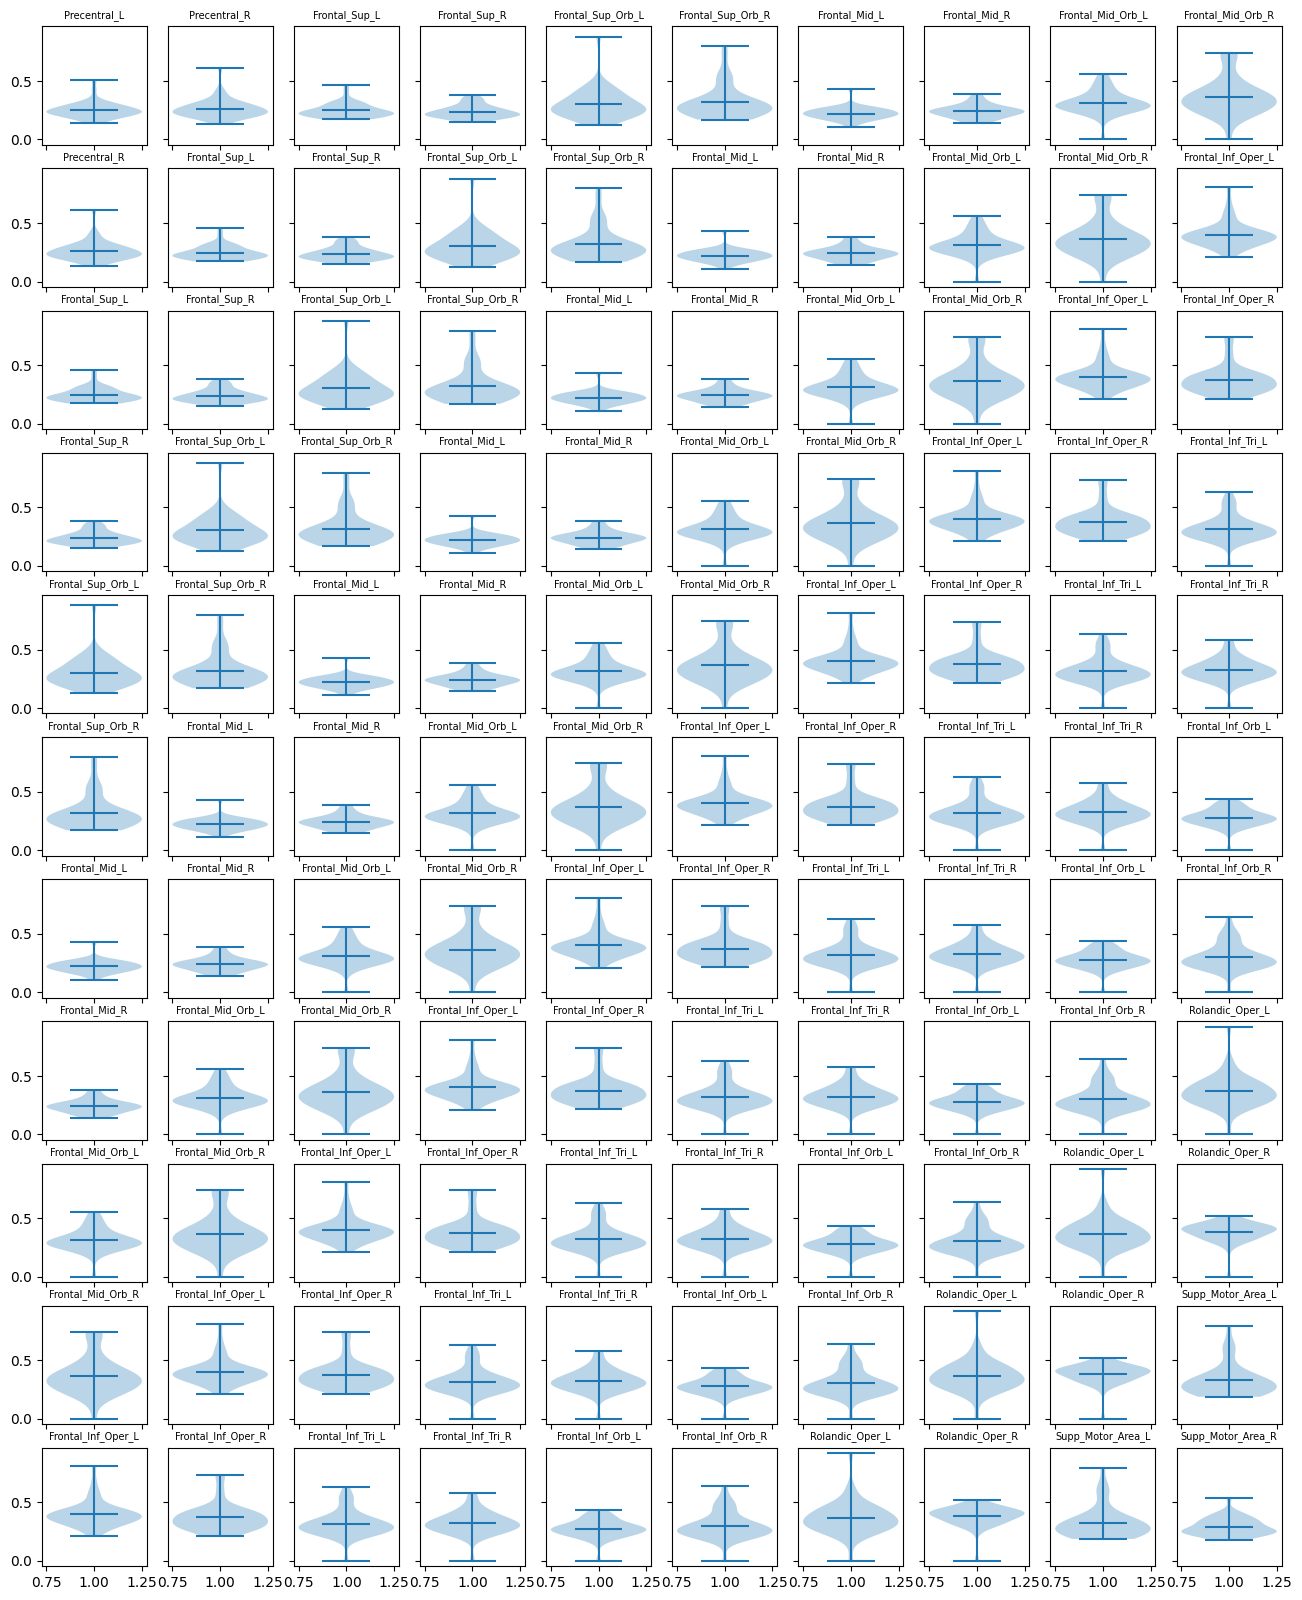

In [24]:
COCGM_PC1_AA_scores_df_cols = COCGM_PC1_AA_scores_df.columns
COCGM_PC1_AA_scores_df.fillna(0, inplace=True)

fig, axs = plt.subplots(11, 10, figsize=(16, 20), sharex=True, sharey=True)

for x in range(11):
    for y in range(10):
        
        current_roi = COCGM_PC1_AA_scores_df.columns[x+y]
        axs[x, y].violinplot(COCGM_PC1_AA_scores_df[current_roi] , vert=True, showmeans=True)
        axs[x, y].set_title(current_roi, fontsize=7)

In [25]:

COCGM_AA_avg_fit = []
COCGM_AA_std_fit = []

for x in range(len(AA_labels)):
    COCGM_AA_avg_fit.append(COCGM_PC1_AA_scores_df[AA_labels[x]].mean(skipna=True))
    COCGM_AA_std_fit.append(COCGM_PC1_AA_scores_df[AA_labels[x]].std(skipna=True))

#COCGM_AA_avg_fit = np.array(COCGM_AA_avg_fit)
#COCGM_AA_avg_fit.T



In [26]:
COCGM_AA_avg_vols = []
COCGM_AA_std_vols = []

for x in range(len(AA_labels)):
    shit_another_mask = aa_roi_masks[x].fit_transform(COC_paths[0])
    runner = shit_another_mask.shape[1]

    score_avg = COCGM_AA_avg_fit[x]
    score_std = COCGM_AA_std_fit[x]

    zeros_avg_mask = np.zeros((1, runner))
    zeros_std_mask = np.zeros((1, runner))
    
    zeros_avg_mask[0, :] = score_avg*100
    zeros_std_mask[0, :] = score_std*100

    COCGM_AA_avg_vols.append(aa_roi_masks[x].inverse_transform(zeros_avg_mask))
    COCGM_AA_std_vols.append(aa_roi_masks[x].inverse_transform(zeros_std_mask))


In [27]:
# Make zero matrix (to get the shape right) ... then run for loop and sum all matrices.
zero_matrix_avg = nl.image.get_data(COCGM_AA_avg_vols[0]).shape
zero_matrix_std = nl.image.get_data(COCGM_AA_std_vols[0]).shape

COC_AA_avg_fit_vis = np.zeros((zero_matrix_avg))
COC_AA_std_fit_vis = np.zeros((zero_matrix_std))

# Run loop for times (number of rois). Each iteration get matrix with PC1 scores for that roi
# And add it to the "COC_AA_COC1_avg_fit_vis."
for x in range(len(AA_labels)):
    current_roi_avg_scores = nl.image.get_data(COCGM_AA_avg_vols[x])
    current_roi_std_scores = nl.image.get_data(COCGM_AA_std_vols[x])

    COC_AA_avg_fit_vis = COC_AA_avg_fit_vis + current_roi_avg_scores
    COC_AA_std_fit_vis = COC_AA_std_fit_vis + current_roi_std_scores

COC_AA_avg_fit_vis = nl.image.new_img_like(AA_maps, COC_AA_avg_fit_vis)
COC_AA_std_fit_vis = nl.image.new_img_like(AA_maps, COC_AA_std_fit_vis)

# Save vol file as ...
COC_AA_avg_fit_vis.to_filename("AA_AveragePC1Scores_COC.nii.gz")
COC_AA_std_fit_vis.to_filename("AA_StdPC1Scores_COC.nii.gz")


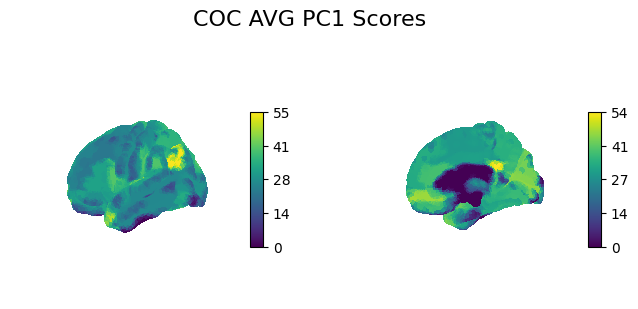

In [28]:
from matplotlib import cm

fsaverage = datasets.fetch_surf_fsaverage()

texture_pial_right = surface.vol_to_surf(COC_AA_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(COC_AA_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("COC AVG PC1 Scores", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
#plt.close()
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True, cmap='viridis', axes=axs2) 
plt.show()



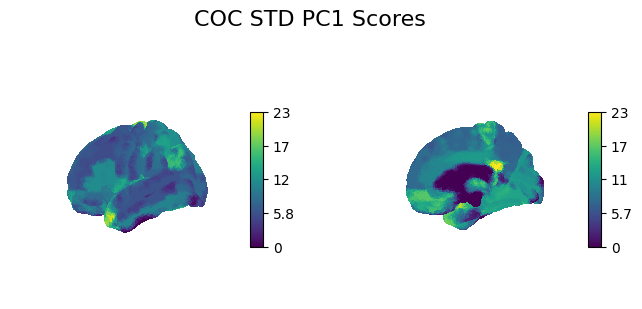

In [30]:
texture_pial_right = surface.vol_to_surf(COC_AA_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=10, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(COC_AA_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=10, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("COC STD PC1 Scores", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True, cmap='viridis', axes=axs2) 
plt.show()


## PLA GM (All)

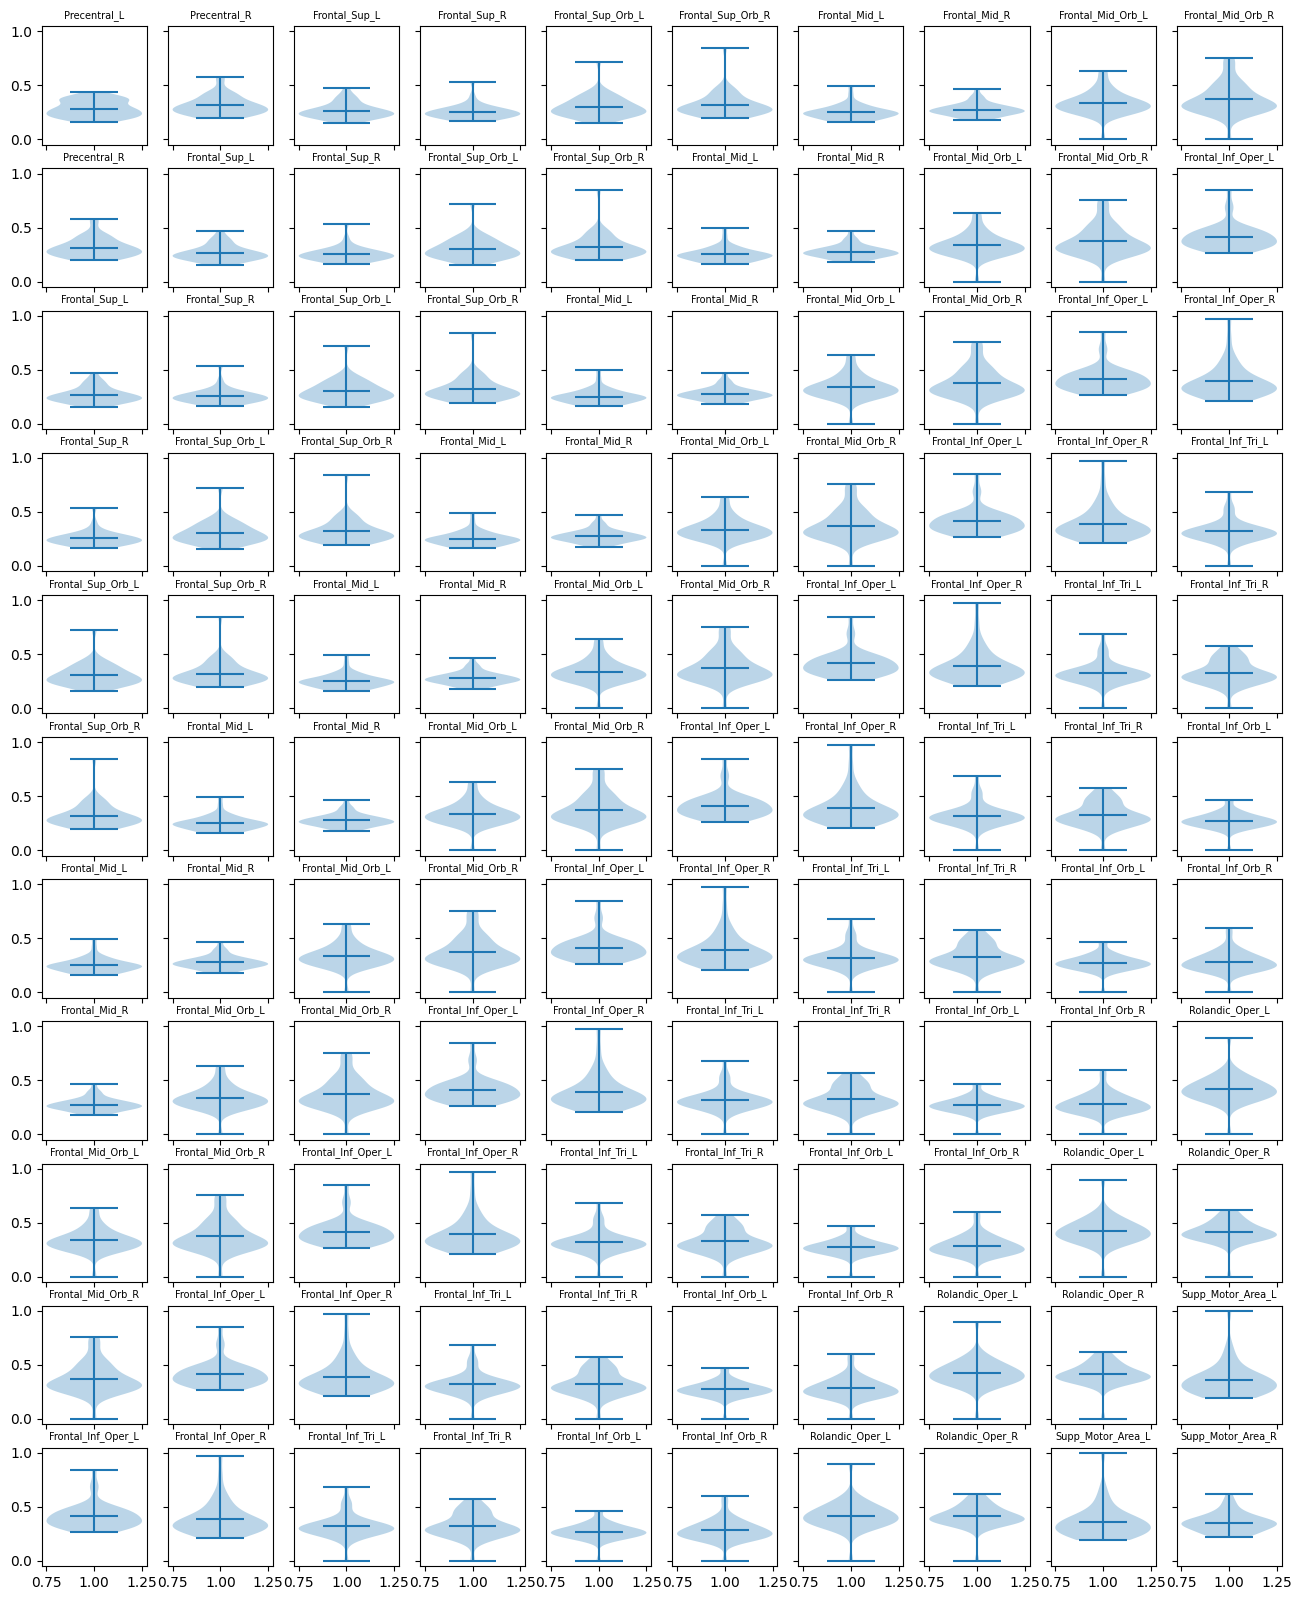

In [31]:
PLAGM_PC1_AA_scores_df_cols = PLAGM_PC1_AA_scores_df.columns
PLAGM_PC1_AA_scores_df.fillna(0, inplace=True)

fig, axs = plt.subplots(11, 10, figsize=(16, 20), sharex=True, sharey=True)

for x in range(11):
    for y in range(10):
        
        current_roi = PLAGM_PC1_AA_scores_df.columns[x+y]
        axs[x, y].violinplot(PLAGM_PC1_AA_scores_df[current_roi] , vert=True, showmeans=True)
        axs[x, y].set_title(current_roi, fontsize=7)

In [32]:

PLAGM_AA_avg_fit = []
PLAGM_AA_std_fit = []

for x in range(len(AA_labels)):
    PLAGM_AA_avg_fit.append(PLAGM_PC1_AA_scores_df[AA_labels[x]].mean(skipna=True))
    PLAGM_AA_std_fit.append(PLAGM_PC1_AA_scores_df[AA_labels[x]].std(skipna=True))
    

In [33]:
PLAGM_AA_avg_vols = []
PLAGM_AA_std_vols = []

for x in range(len(AA_labels)):
    #print("run: " +str(x))
    shit_another_mask = aa_roi_masks[x].fit_transform(PLA_paths[0])

    runner = shit_another_mask.shape[1]
    
    score_avg = PLAGM_AA_avg_fit[x]
    score_std = PLAGM_AA_std_fit[x]
    
    zeros_avg_mask = np.zeros((1, runner))
    zeros_std_mask = np.zeros((1, runner))
    
    zeros_avg_mask[0, :] = score_avg*100
    zeros_std_mask[0, :] = score_std*100

    PLAGM_AA_avg_vols.append(aa_roi_masks[x].inverse_transform(zeros_avg_mask))
    PLAGM_AA_std_vols.append(aa_roi_masks[x].inverse_transform(zeros_std_mask))

In [34]:
# Make zero matrix (to get the shape right) ... then run for loop and sum all matrices.
zero_avg_matrix = nl.image.get_data(PLAGM_AA_avg_vols[0]).shape
zero_std_matrix = nl.image.get_data(PLAGM_AA_std_vols[0]).shape

PLA_AA_avg_fit_vis = np.zeros((zero_avg_matrix))
PLA_AA_std_fit_vis = np.zeros((zero_std_matrix))

# Run loop for times (number of rois). Each iteration get matrix with PC1 scores for that roi
# And add it to the "COC_AA_COC1_avg_fit_vis."
for x in range(len(AA_labels)):
    current_roi_avg_scores = nl.image.get_data(PLAGM_AA_avg_vols[x])
    current_roi_std_scores = nl.image.get_data(PLAGM_AA_std_vols[x])

    PLA_AA_avg_fit_vis = PLA_AA_avg_fit_vis + current_roi_avg_scores
    PLA_AA_std_fit_vis = PLA_AA_std_fit_vis + current_roi_std_scores

PLA_AA_avg_fit_vis = nl.image.new_img_like(AA_maps, PLA_AA_avg_fit_vis)
PLA_AA_std_fit_vis = nl.image.new_img_like(AA_maps, PLA_AA_std_fit_vis)

# Save vol file as ...
PLA_AA_avg_fit_vis.to_filename("AA_AveragePC1Scores_PLA.nii.gz")
PLA_AA_avg_fit_vis.to_filename("AA_StdPC1Scores_PLA.nii.gz")


In [189]:
#texture = surface.vol_to_surf(PLA_AA_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=1, interpolation="nearest")

#figure = plotting.view_surf(fsaverage.pial_right, texture, cmap='viridis', symmetric_cmap=False) 

#figure

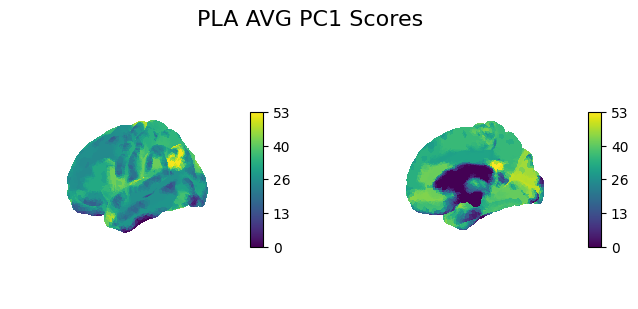

In [35]:
texture_pial_right = surface.vol_to_surf(PLA_AA_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=5, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(PLA_AA_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=5, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("PLA AVG PC1 Scores", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True,  cmap='viridis', axes=axs2) 
plt.show()

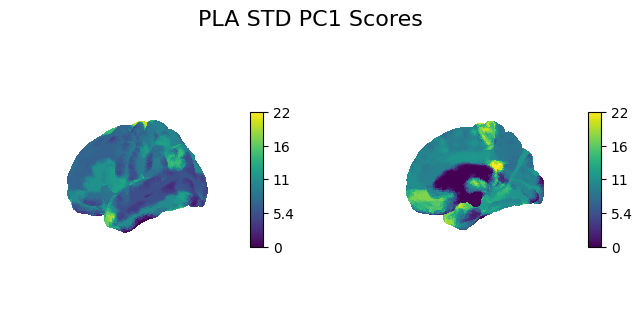

In [36]:
texture_pial_right = surface.vol_to_surf(PLA_AA_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=5, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(PLA_AA_std_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=5, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("PLA STD PC1 Scores", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True,  cmap='viridis', axes=axs2) 
plt.show()

## Change scores (COC - PLA) (All)

In [215]:
# Create new df with change scores for each participant and each roi. 
Change_PC1_AA_scores_df = pd.DataFrame(columns=AA_labels, index=COCGM_PC1_AA_scores_df.index)

for x in range(40):
    Change_PC1_AA_scores_df.iloc[x] = COCGM_PC1_AA_scores_df.iloc[x] - PLAGM_PC1_AA_scores_df.iloc[x]

#Change_PC1_AA_scores_df


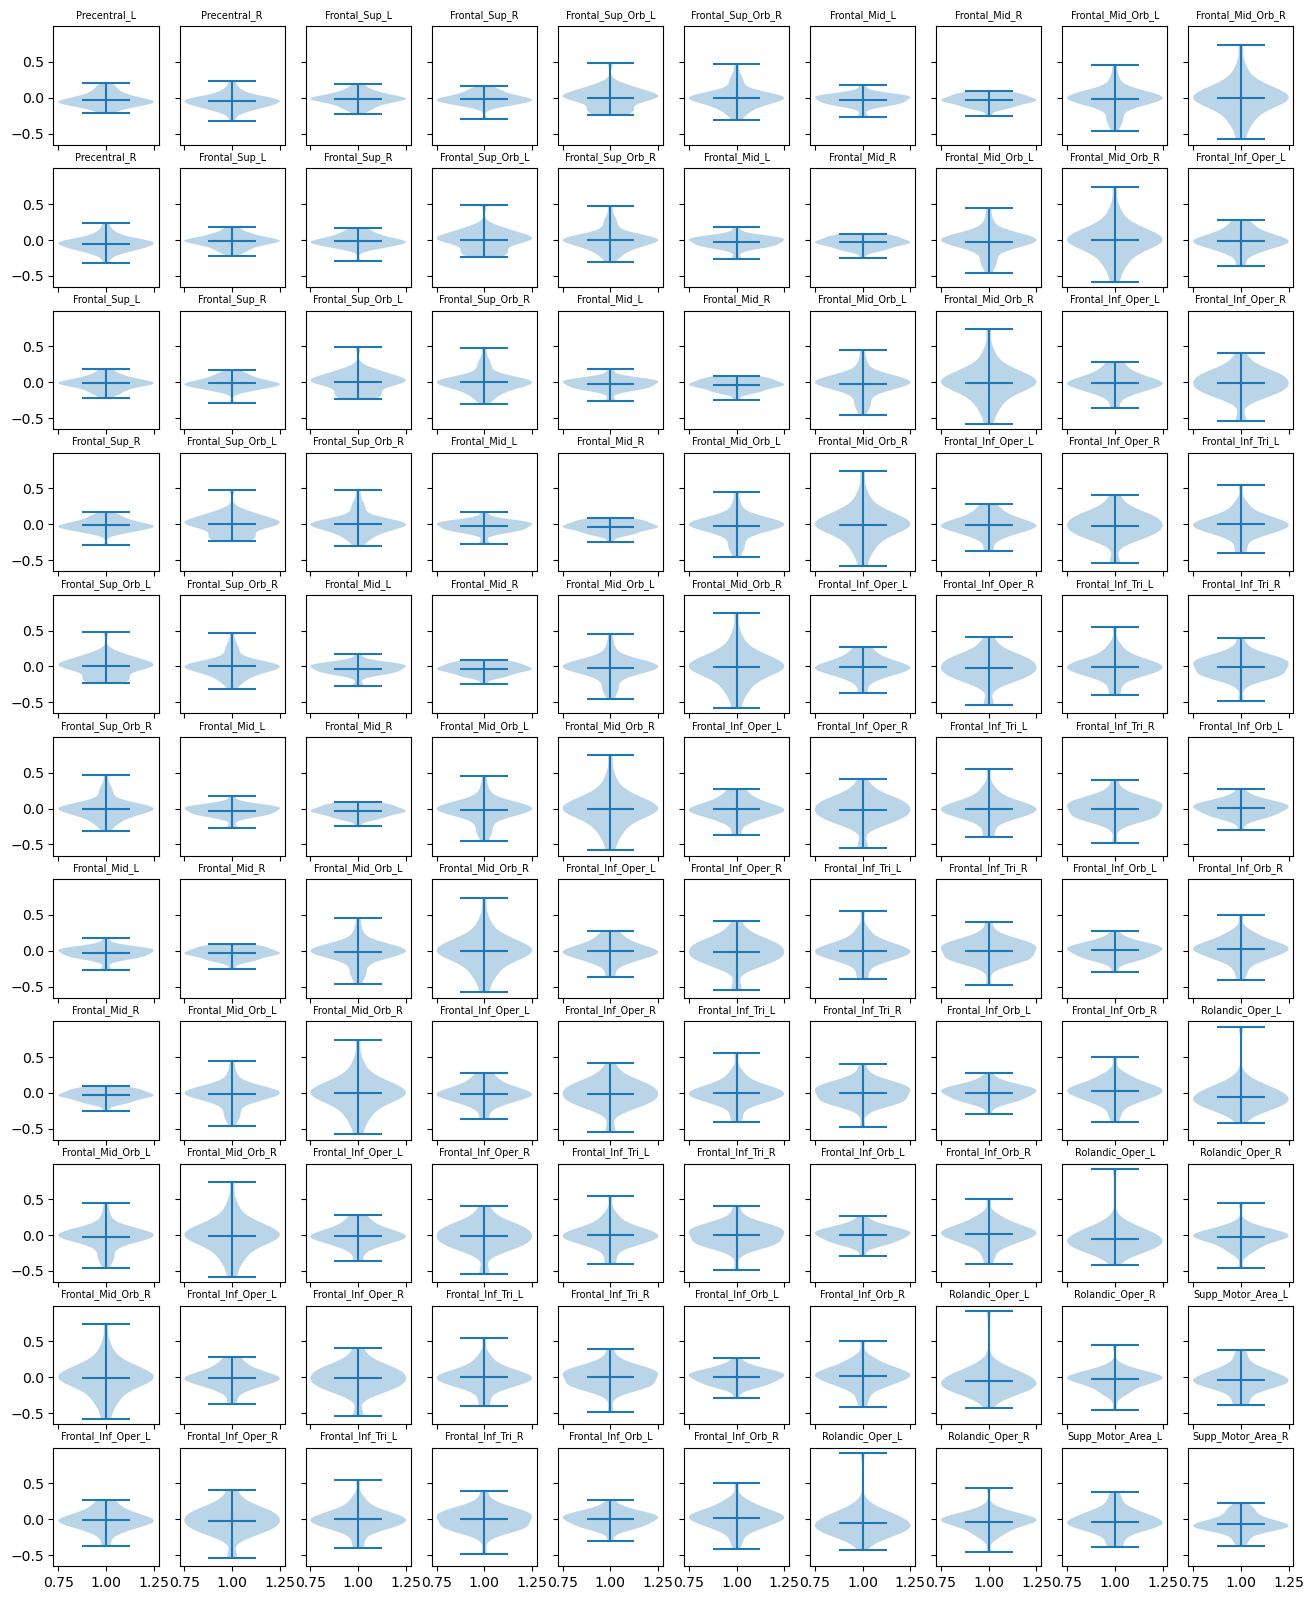

In [216]:
Change_PC1_AA_scores_df_cols = Change_PC1_AA_scores_df.columns
Change_PC1_AA_scores_df.fillna(0, inplace=True)

fig, axs = plt.subplots(11, 10, figsize=(16, 20), sharex=True, sharey=True)

for x in range(11):
    for y in range(10):
        
        current_roi = Change_PC1_AA_scores_df.columns[x+y]
        axs[x, y].violinplot(Change_PC1_AA_scores_df[current_roi], vert=True, showmeans=True)
        axs[x, y].set_title(current_roi, fontsize=7)

In [223]:

ChangeGM_AA_avg_fit = []

for x in range(len(AA_labels)):
    ChangeGM_AA_avg_fit.append(Change_PC1_AA_scores_df[AA_labels[x]].mean(skipna=True))

In [225]:
ChangeGM_AA_avg_vols = []

for x in range(len(AA_labels)):
    #print("run: " +str(x))
    shit_another_mask = aa_roi_masks[x].fit_transform(PLA_paths[0])
    runner = shit_another_mask.shape[1]
    score = ChangeGM_AA_avg_fit[x]
    zeros_mask = np.zeros((1, runner))
    zeros_mask[0, :] = score*100
    ChangeGM_AA_avg_vols.append(aa_roi_masks[x].inverse_transform(zeros_mask))

In [226]:
# Make zero matrix (to get the shape right) ... then run for loop and sum all matrices.
zero_matrix = nl.image.get_data(PLAGM_AA_avg_vols[0]).shape
Change_AA_avg_fit_vis = np.zeros((zero_matrix))

# Run loop for times (number of rois). Each iteration get matrix with PC1 scores for that roi
# And add it to the "COC_AA_COC1_avg_fit_vis."
for x in range(len(AA_labels)):
    current_roi_scores = nl.image.get_data(ChangeGM_AA_avg_vols[x])
    Change_AA_avg_fit_vis = Change_AA_avg_fit_vis + current_roi_scores

Change_AA_avg_fit_vis = nl.image.new_img_like(AA_maps, Change_AA_avg_fit_vis)

# Save vol file as ...
Change_AA_avg_fit_vis.to_filename("AA_AveragePC1Scores_Change.nii.gz")

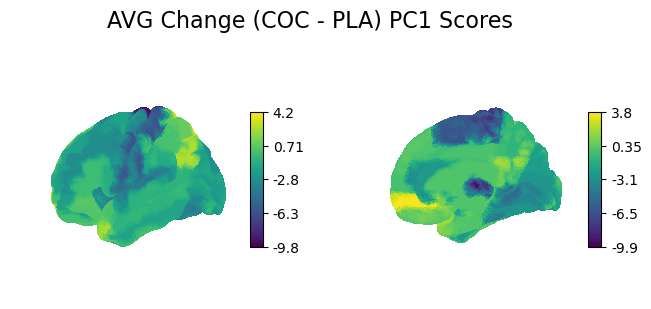

In [227]:
texture_pial_right = surface.vol_to_surf(Change_AA_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_right, n_samples=5, interpolation="nearest")
texture_pial_left = surface.vol_to_surf(Change_AA_avg_fit_vis.slicer[:, :, :, 0], fsaverage.pial_left, n_samples=5, interpolation="nearest")

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True, subplot_kw={"projection": "3d"}) 
fig.suptitle("AVG Change (COC - PLA) PC1 Scores", fontsize=16)
axs1.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs1.yaxis.set_tick_params(labelleft=False, left=False)
axs2.xaxis.set_tick_params(labelbottom=False, bottom=False)
axs2.yaxis.set_tick_params(labelleft=False, left=False)

plotting.plot_surf(fsaverage.pial_left, texture_pial_left, colorbar=True, cmap='viridis', axes=axs1) 
#plt.close()
plotting.plot_surf(fsaverage.pial_right, texture_pial_right, colorbar=True,  cmap='viridis', axes=axs2) 
plt.show()

In [230]:
#Change_PC1_AA_scores_df.to_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/AAL_COCPLA_Change_PC1_scores.csv')